## Key concepts

In [20]:
import jax
import jax.numpy as jnp
import numpy as np

# jax arrays
x=jnp.arange(5)
isinstance(x, jax.Array) #check if something is a jax array

#Jax includes transformation which operate on jax functions
# jit: just in time compilation
# vmap: vectorizing transform (this one we need to understand)
# grad: gradient transform

def selu(x, alpha=1.67, lambda_=1.05):
  return lambda_ * jnp.where(x > 0, x, alpha * jnp.exp(x) - alpha) #damn I didnt even know this is how np.where can be used

selu_jit=jax.jit(selu)
print(selu_jit(1))


@jax.jit #or use a decorator
def selu(x, alpha=1.67, lambda_=1.05):
  return lambda_ * jnp.where(x > 0, x, alpha * jnp.exp(x) - alpha)


#tracing
@jax.jit
def f(x):
  print(x)
  return x + 1

x = jnp.arange(5)
result = f(x)

# THe value printed by x is not the array, but rather essential atributes of x, such as it shape and type. By executing the function with traced values
# Jax can determine the sequence of operations encded by the function before those operations are actually executed. 

#transformations like jit, vmap and grad can then map this sequence of input operations to a transformed sequence of operations.



1.05
Traced<ShapedArray(int32[5])>with<DynamicJaxprTrace(level=1/0)>


In [27]:
#jaxprs: jax has its own intermediate representation for sequences of operations: a jaxpr
x=jnp.arange(5.0)
jax.make_jaxpr(selu)(x)

#Jax internals: the jaxpr language (where htey go more into depth)

### Pytrees
# (nested) list of parameters
params = [1, 2, (jnp.arange(3), jnp.ones(2))]

print(jax.tree.structure(params))
print(jax.tree.leaves(params))

# Dictionary of parameters
params = {'n': 5, 'W': jnp.ones((2, 2)), 'b': jnp.zeros(2)}

print(jax.tree.structure(params))
print(jax.tree.leaves(params))

# Named tuple of parameters
from typing import NamedTuple

class Params(NamedTuple):
  a: int
  b: float

params = Params(1, 5.0)
print(jax.tree.structure(params))
print(jax.tree.leaves(params))


#Jax has a number of general-purpose utilities for working with PyTrees; for example the functions 
# jax.tree.map() can be used to map a function to every leaf in a tree,
# jax.tree.reduce() can be used to apply a reduction across the leaves in a tree
# https://jax.readthedocs.io/en/latest/working-with-pytrees.html#working-with-pytrees

PyTreeDef([*, *, (*, *)])
[1, 2, Array([0, 1, 2], dtype=int32), Array([1., 1.], dtype=float32)]
PyTreeDef({'W': *, 'b': *, 'n': *})
[Array([[1., 1.],
       [1., 1.]], dtype=float32), Array([0., 0.], dtype=float32), 5]
PyTreeDef(CustomNode(namedtuple[Params], [*, *]))
[1, 5.0]


## Just in-time compilation

In [28]:
def selu(x, alpha=1.67, lambda_=1.05):
  return lambda_ * jnp.where(x > 0, x, alpha * jnp.exp(x) - alpha)

x = jnp.arange(1000000)
%timeit selu(x).block_until_ready()

2.14 ms ± 221 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [29]:
selu_jit = jax.jit(selu)

# Pre-compile the function before timing...
selu_jit(x).block_until_ready()

%timeit selu_jit(x).block_until_ready()


266 µs ± 23 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


## Automatic vectorization

In [49]:
#vectorization
x = jnp.arange(5)
w = jnp.array([2., 3., 4.])

def convolve(x, w):
  output = []
  for i in range(1, len(x)-1):

    output.append(jnp.dot(x[i-1:i+2], w))
  return jnp.array(output)

np.dot([0,1,2],[2,3,4])

#suppose we want to apply this function to a stack of weights w to a batch of vectors x
xs=jnp.stack([x,x])
ws=jnp.stack([w,w])

#the naive option
def manually_batched_convolve(xs, ws):
  output = []
  for i in range(xs.shape[0]):
    output.append(convolve(xs[i], ws[i]))
  return jnp.stack(output)

manually_batched_convolve(xs, ws)

# you could rewrite the function

def manually_vectorized_convolve(xs, ws):
  output = []
  for i in range(1, xs.shape[-1] -1):
    output.append(jnp.sum(xs[:, i-1:i+2] * ws, axis=1))
  return jnp.stack(output, axis=1)

manually_vectorized_convolve(xs, ws)

#or jax has a fucntion called vmap, which automatically vectorizes the implementation of a function
auto_batch_convolve=jax.vmap(convolve)
auto_batch_convolve(xs, ws)

# if the batch dimension is not the first, then you may use in_axes and out_axes to specifiy the location of the batch dimension in inputs
auto_batch_convolve_v2 = jax.vmap(convolve, in_axes=1, out_axes=1)

xst = jnp.transpose(xs)
wst = jnp.transpose(ws)

auto_batch_convolve_v2(xst, wst)

#it also supports the case where only on of the arguments is batched: for example if you would like to convolve to a single set of weights w with a batch of vectors
#x
batch_convolve_v3 = jax.vmap(convolve, in_axes=[0, None])

batch_convolve_v3(xs, w)

#transformations can be combinated
jitted_batch_convolve = jax.jit(auto_batch_convolve)

jitted_batch_convolve(xs, ws)

Array([[11., 20., 29.],
       [11., 20., 29.]], dtype=float32)

## Automatic differentation


In [66]:
from jax import grad

grad_tanh = grad(jnp.tanh)
print(grad_tanh(2.0))

print(grad(grad(jnp.tanh))(2.0))
print(grad(grad(grad(jnp.tanh)))(2.0))

f = lambda x: x**3 + 2*x**2 - 3*x + 1
dfdx=jax.grad(f)
d2fdx = jax.grad(dfdx)
d3fdx = jax.grad(d2fdx)
d4fdx = jax.grad(d3fdx)

print(dfdx(1.))
print(d2fdx(1.))
print(d3fdx(1.))
print(d4fdx(1.))




0.070650816
-0.13621868
0.25265405
4.0
10.0
6.0
0.0


In [70]:
## Computing gradients in a linear logistic regression
key = jax.random.key(0)
def sigmoid(x):
  return 0.5 * (jnp.tanh(x / 2) + 1)

# Outputs probability of a label being true.
def predict(W, b, inputs):
  return sigmoid(jnp.dot(inputs, W) + b)

# Build a toy dataset.
inputs = jnp.array([[0.52, 1.12,  0.77],
                    [0.88, -1.08, 0.15],
                    [0.52, 0.06, -1.30],
                    [0.74, -2.49, 1.39]])
targets = jnp.array([True, True, False, True])


# Training loss is the negative log-likelihood of the training examples.
def loss(W, b):
  preds = predict(W, b, inputs)
  label_probs = preds * targets + (1 - preds) * (1 - targets)
  return -jnp.sum(jnp.log(label_probs))


# Initialize random model coefficients
key, W_key, b_key = jax.random.split(key, 3)
W = jax.random.normal(W_key, (3,))
b = jax.random.normal(b_key, ())

In [73]:
# Differentiate loss with respect to the first position argument
W_grad=grad(loss,argnums=0)(W,b)
# Since argnums=0 is the default, this does the same thing:
W_grad = grad(loss)(W, b)
print(f'{W_grad=}')

# But you can choose different values too, and drop the keyword:
b_grad = grad(loss, 1)(W, b)
print(f'{b_grad=}')

# Including tuple values
W_grad, b_grad = grad(loss, (0, 1))(W, b)
print(f'{W_grad=}')
print(f'{b_grad=}')

W_grad=Array([-0.16965583, -0.8774644 , -1.4901346 ], dtype=float32)
b_grad=Array(-0.29227245, dtype=float32)
W_grad=Array([-0.16965583, -0.8774644 , -1.4901346 ], dtype=float32)
b_grad=Array(-0.29227245, dtype=float32)


In [74]:
## Due to Jax's pytree abstraction, differentiating with respect to standard Python containers just works, so use tuples, lists, and dicts (and arbitrary nesting) 
#however you like 

def loss2(params_dict):
    preds = predict(params_dict['W'], params_dict['b'], inputs)
    label_probs = preds * targets + (1 - preds) * (1 - targets)
    return -jnp.sum(jnp.log(label_probs))

print(grad(loss2)({'W': W, 'b': b})) #we can easily the loss given the parameters using a very simple sturcture.

{'W': Array([-0.16965583, -0.8774644 , -1.4901346 ], dtype=float32), 'b': Array(-0.29227245, dtype=float32)}


## Pytree

In [75]:
example_trees = [
    [1, 'a', object()],
    (1, (2, 3), ()),
    [1, {'k1': 2, 'k2': (3, 4)}, 5],
    {'a': 2, 'b': (2, 3)},
    jnp.array([1, 2, 3]),
]

# Print how many leaves the pytrees have.
for pytree in example_trees:
  # This `jax.tree.leaves()` method extracts the flattened leaves from the pytrees.
  leaves = jax.tree.leaves(pytree)
  print(f"{repr(pytree):<45} has {len(leaves)} leaves: {leaves}")

[1, 'a', <object object at 0x7ddcac837a40>]   has 3 leaves: [1, 'a', <object object at 0x7ddcac837a40>]
(1, (2, 3), ())                               has 3 leaves: [1, 2, 3]
[1, {'k1': 2, 'k2': (3, 4)}, 5]               has 5 leaves: [1, 2, 3, 4, 5]
{'a': 2, 'b': (2, 3)}                         has 3 leaves: [2, 2, 3]
Array([1, 2, 3], dtype=int32)                 has 1 leaves: [Array([1, 2, 3], dtype=int32)]


In [94]:
list_of_lists = [
    [1, 2, 3],
    [1, 2],
    [1, 2, 3, 4]
]


jax.tree.map(lambda x: x*2, list_of_lists)

#also seems very useful, you can map easy operations on all operations in a pytree

#example of jax.tree.map with ML model parameters
def init_mlp_params(layer_widths):
  params = []
  for n_in, n_out in zip(layer_widths[:-1], layer_widths[1:]):
    params.append(
        dict(weights=np.random.normal(size=(n_in, n_out)) * np.sqrt(2/n_in),
             biases=np.ones(shape=(n_out,))
            )
    )
  return params

params = init_mlp_params([1, 128, 128, 1])
jax.tree.map(lambda x: x.shape, params)

#define the functions for training the MLP model
# Define the forward pass.
def forward(params, x):
  *hidden, last = params
  for layer in hidden:
    x = jax.nn.relu(x @ layer['weights'] + layer['biases'])
  return x @ last['weights'] + last['biases'] # @ is an infix matrix multiplication operator


# Define the loss function.
def loss_fn(params, x, y):
  return jnp.mean((forward(params, x) - y) ** 2)


# Set the learning rate.
LEARNING_RATE = 0.0001


# Using the stochastic gradient descent, define the parameter update function.
# Apply `@jax.jit` for JIT compilation (speed).
@jax.jit
def update(params, x, y):
  # Calculate the gradients with `jax.grad`.
  grads = jax.grad(loss_fn)(params, x, y)
  # Note that `grads` is a pytree with the same structure as `params`.
  # `jax.grad` is one of many JAX functions that has
  # built-in support for pytrees.
  # This is useful - you can apply the SGD update using JAX pytree utilities.
  return jax.tree.map(
      lambda p, g: p - LEARNING_RATE * g, params, grads
  )



## Custom pytree nodes
class Special(object):
  def __init__(self, x, y):
    self.x = x
    self.y = y

jax.tree.leaves([
    Special(0, 1),
    Special(2, 4),
])

# jax.tree.map(lambda x: x + 1,
#   [
#     Special(0, 1),
#     Special(2, 4)
#   ])


class RegisteredSpecial(Special):
  def __repr__(self):
    return "RegisteredSpecial(x={}, y={})".format(self.x, self.y)
  

def special_flatten(v):
  """Specifies a flattening recipe.

  Params:
    v: The value of the registered type to flatten.
  Returns:
    A pair of an iterable with the children to be flattened recursively,
    and some opaque auxiliary data to pass back to the unflattening recipe.
    The auxiliary data is stored in the treedef for use during unflattening.
    The auxiliary data could be used, for example, for dictionary keys.
  """
  children = (v.x, v.y)
  aux_data = None
  return (children, aux_data)


def special_unflatten(aux_data, children):
  """Specifies an unflattening recipe.

  Params:
    aux_data: The opaque data that was specified during flattening of the
      current tree definition.
    children: The unflattened children

  Returns:
    A reconstructed object of the registered type, using the specified
    children and auxiliary data.
  """
  return RegisteredSpecial(*children)



# Global registration
jax.tree_util.register_pytree_node(
    RegisteredSpecial,
    special_flatten,    # Instruct JAX what are the children nodes.
    special_unflatten   # Instruct JAX how to pack back into a `RegisteredSpecial`.
)

jax.tree.map(lambda x: x + 1,
  [
   RegisteredSpecial(0, 1),
   RegisteredSpecial(2, 4),
  ])

# I do not completely get this yet.
from typing import NamedTuple, Any
#Modern python comes equipped with helpful tools to make defining containers easier. Some will work with JAX out of the box
class MyOtherContainer(NamedTuple):
  name: str
  a: Any
  b: Any
  c: Any


# NamedTuple subclasses are handled as pytree nodes, so
# this will work out-of-the-box.
jax.tree.leaves([
    MyOtherContainer('Alice', 1, 2, 3),
    MyOtherContainer('Bob', 4, 5, 6)
])


['Alice', 1, 2, 3, 'Bob', 4, 5, 6]

In [114]:
def Sv(S,v):
    return S@v


S=jnp.ones((5,100))
v=jnp.ones(100)
Sv_jit=jax.jit(Sv)


%timeit Sv(S,v)
%timeit S@v
%timeit Sv_jit(S,v).block_until_ready()
%timeit np.ones((5,100))@np.ones(100)
#something else

4.35 µs ± 16.4 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
4.28 µs ± 31.8 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
3.75 µs ± 36.4 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
3.04 µs ± 17 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


## Stateful computations
Jax transformations like jit vmap and grad require the function they wrap to be pure: that is functions whose outputs depend soleley on the inputs. 
This can impose some challenges in the context of machine learning, where state may exist in many forms
1. Model parameters
2. Optimizer state
3. stateful layers

In [113]:
class Counter:
  """A simple counter."""

  def __init__(self):
    self.n = 0

  def count(self) -> int:
    """Increments the counter and returns the new value."""
    self.n += 1
    return self.n

  def reset(self):
    """Resets the counter to zero."""
    self.n = 0


counter = Counter()

for _ in range(3):
  print(counter.count())

counter.reset()
fast_count = jax.jit(counter.count)

for _ in range(3):
  print(fast_count()) #self.n+=1 in count invovles a side effect: it modifies the input counter in-place, and so this function is not supported by jit
  #Such side effects are executed only once when the function is first traced, and subsequent calls will not repreat the side effects.


#we can resolve this by making the state of counter an  explicit state
CounterState = int

class CounterV2:

  def count(self, n: CounterState) -> tuple[int, CounterState]:
    # You could just return n+1, but here we separate its role as 
    # the output and as the counter state for didactic purposes.
    return n+1, n+1

  def reset(self) -> CounterState:
    return 0

counter = CounterV2()
state = counter.reset()

for _ in range(3):
  value, state = counter.count(state)
  print(value)

state = counter.reset()
fast_count = jax.jit(counter.count)

for _ in range(3):
  value, state = fast_count(state)
  print(value)

#this is a general strategy: we can apply the same process to any stateful method to convert it into a stateless one
# class StatefulClass

#   state: State

#   def stateful_method(*args, **kwargs) -> Output:

# class StatelessClass

#   def stateless_method(state: State, *args, **kwargs) -> (Output, State):


1
2
3
1
1
1
1
2
3
1
2
3


### A simple worked example
Linear regression via Gradient Descent

Params(weight=Array(0.13790321, dtype=float32), bias=Array(1.3694694, dtype=float32))
Params(weight=Array(0.16085331, dtype=float32), bias=Array(1.3447553, dtype=float32))
Params(weight=Array(0.18351987, dtype=float32), bias=Array(1.3203032, dtype=float32))
Params(weight=Array(0.20590638, dtype=float32), bias=Array(1.2961103, dtype=float32))
Params(weight=Array(0.22801626, dtype=float32), bias=Array(1.2721739, dtype=float32))
Params(weight=Array(0.24985291, dtype=float32), bias=Array(1.2484912, dtype=float32))
Params(weight=Array(0.27141967, dtype=float32), bias=Array(1.2250594, dtype=float32))
Params(weight=Array(0.29271987, dtype=float32), bias=Array(1.2018759, dtype=float32))
Params(weight=Array(0.31375676, dtype=float32), bias=Array(1.1789382, dtype=float32))
Params(weight=Array(0.33453357, dtype=float32), bias=Array(1.1562433, dtype=float32))
Params(weight=Array(0.35505348, dtype=float32), bias=Array(1.133789, dtype=float32))
Params(weight=Array(0.37531966, dtype=float32), bias=Ar

/tmp/ipykernel_9334/1820282211.py:37: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  new_params = jax.tree_map(


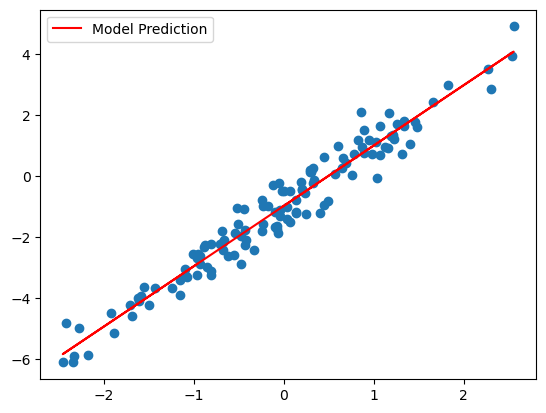

In [119]:
from typing import NamedTuple

class Params(NamedTuple):
  weight: jnp.ndarray
  bias: jnp.ndarray



def init(rng) -> Params:
  """Returns the initial model params."""
  weights_key, bias_key = jax.random.split(rng)
  weight = jax.random.normal(weights_key, ())
  bias = jax.random.normal(bias_key, ())
  return Params(weight, bias)

def loss(params: Params, x: jnp.ndarray, y: jnp.ndarray) -> jnp.ndarray:
  """Computes the least squares error of the model's predictions on x against y."""
  pred = params.weight * x + params.bias
  return jnp.mean((pred - y) ** 2)


LEARNING_RATE = 0.005

@jax.jit
def update(params: Params, x: jnp.ndarray, y: jnp.ndarray) -> Params:
  """Performs one SGD update step on params using the given data."""
  grad = jax.grad(loss)(params, x, y)

  # If we were using Adam or another stateful optimizer,
  # we would also do something like
  #
  #   updates, new_optimizer_state = optimizer(grad, optimizer_state)
  # 
  # and then use `updates` instead of `grad` to actually update the params.
  # (And we'd include `new_optimizer_state` in the output, naturally.)

  new_params = jax.tree_map(
      lambda param, g: param - g * LEARNING_RATE, params, grad)

  return new_params

#we manually pipe the params in and out of the update function.

import matplotlib.pyplot as plt

rng = jax.random.key(42)

# Generate true data from y = w*x + b + noise
true_w, true_b = 2, -1
x_rng, noise_rng = jax.random.split(rng)
xs = jax.random.normal(x_rng, (128, 1))
noise = jax.random.normal(noise_rng, (128, 1)) * 0.5
ys = xs * true_w + true_b + noise

# Fit regression
params = init(rng)
for _ in range(1000):
  print(params)
  params = update(params, xs, ys)

plt.scatter(xs, ys)
plt.plot(xs, params.weight * xs + params.bias, c='red', label='Model Prediction')
plt.legend();
